# EV Charging Data Cleaning & Preparation

This notebook standardizes timestamps, validates durations, removes invalid and extreme outliers, and saves a clean dataset for modeling.

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import timedelta

pd.set_option('display.max_columns', None)

RAW_PATH = '../../data/trondheim/Dataset 1_EV charging reports.csv'
OUT_DIR = 'data'
OUT_FILE = os.path.join(OUT_DIR, 'ev_sessions_clean.csv')

print('Configured paths:')
print('  RAW_PATH:', RAW_PATH)
print('  OUT_FILE:', OUT_FILE)

Configured paths:
  RAW_PATH: ../../data/trondheim/Dataset 1_EV charging reports.csv
  OUT_FILE: data/ev_sessions_clean.csv


## 1) Load data
Read CSV with European decimal/comma and semicolon separator.

In [2]:
df = pd.read_csv(RAW_PATH, sep=';', decimal=',')
rows_before = len(df)
print('Raw shape:', df.shape)
df.head(3)

Raw shape: (6878, 15)


,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category
0,1,AdO3,AdO3-4,Private,NaN,21.12.2018 10:20,10,21.12.2018 10:23,10.0,0.30,0.050000,Dec,Friday,late morning (9-12),Less than 3 hours
1,2,AdO3,AdO3-4,Private,NaN,21.12.2018 10:24,10,21.12.2018 10:32,10.0,0.87,0.136667,Dec,Friday,late morning (9-12),Less than 3 hours
2,3,AdO3,AdO3-4,Private,NaN,21.12.2018 11:33,11,21.12.2018 19:46,19.0,29.87,8.216389,Dec,Friday,late morning (9-12),Between 6 and 9 hours


## 2) Parse timestamps and recompute duration
We parse day-first timestamps, ensure order, and reconcile duration.

In [ ]:
# Parse timestamps
df['Start_plugin_dt'] = pd.to_datetime(df['Start_plugin'], dayfirst=True, errors='coerce')
df['End_plugout_dt'] = pd.to_datetime(df['End_plugout'], dayfirst=True, errors='coerce')

# Drop rows with unparseable dates
bad_dates = df['Start_plugin_dt'].isna().sum() + df['End_plugout_dt'].isna().sum()
df = df.dropna(subset=['Start_plugin_dt', 'End_plugout_dt']).copy()

# Ensure end after start
mask_bad_order = df['End_plugout_dt'] < df['Start_plugin_dt']
bad_order = int(mask_bad_order.sum())
df = df[~mask_bad_order].copy()

# Recompute duration in hours
df['Duration_hours_calc'] = (df['End_plugout_dt'] - df['Start_plugin_dt']).dt.total_seconds() / 3600.0

# Replace duration if mismatched by > 0.5 hours
mismatch = (df['Duration_hours'].sub(df['Duration_hours_calc']).abs() > 0.5)
replaced = int(mismatch.sum())
df.loc[mismatch, 'Duration_hours'] = df.loc[mismatch, 'Duration_hours_calc']

print(f'Unparseable dates dropped: {bad_dates}')
print(f'Bad end<start dropped:   {bad_order}')
print(f'Duration replaced (>0.5h mismatch): {replaced}')
print('Shape after timestamp checks:', df.shape)

## 3) Remove invalid values and extreme outliers
- Remove `El_kWh <= 0`
- Remove `Duration_hours <= 0.05` (plug/unplug tests)
- Remove `Duration_hours > 200` hours (very long sessions not representative)

In [ ]:
n0_energy = int((df['El_kWh'] <= 0).sum())
n_short   = int((df['Duration_hours'] <= 0.05).sum())
n_long    = int((df['Duration_hours'] > 200).sum())

df = df[(df['El_kWh'] > 0) & (df['Duration_hours'] > 0.05) & (df['Duration_hours'] <= 200)].copy()

print('Removed due to El_kWh <= 0: ', n0_energy)
print('Removed due to Duration <= 0.05h: ', n_short)
print('Removed due to Duration > 200h: ', n_long)
print('Shape after removals:', df.shape)

## 4) Refresh derived temporal features
Recompute hour, weekday, month from parsed timestamps to ensure consistency.

In [ ]:
df['Start_plugin_hour'] = df['Start_plugin_dt'].dt.hour
df['End_plugout_hour'] = df['End_plugout_dt'].dt.hour
df['weekdays_plugin'] = df['Start_plugin_dt'].dt.day_name()
df['month_plugin'] = df['Start_plugin_dt'].dt.strftime('%b')
df['date'] = df['Start_plugin_dt'].dt.date

print('Derived features refreshed. Columns now include:',
      ['Start_plugin_hour','End_plugout_hour','weekdays_plugin','month_plugin','date'][:])

## 5) Post-cleaning summary
Counts removed and remaining distribution by month.

In [6]:
rows_after = len(df)
print('Rows before:', rows_before)
print('Rows after :', rows_after)
print('Removed    :', rows_before - rows_after)

print('Sessions by month (after cleaning):')
print(df['month_plugin'].value_counts().sort_index())

Rows before: 6878
Rows after : 6878
Removed    : 0
Sessions by month (after cleaning):
month_plugin
Apr     306
Aug     362
Dec    1143
Feb     135
Jan    1361
Jul     238
Jun     291
Mar     301
May     288
Nov    1107
Oct     845
Sep     501
Name: count, dtype: int64


## 6) Save cleaned dataset
Creates the `data/` folder next to this notebook if needed and writes `ev_sessions_clean.csv`.

In [ ]:
os.makedirs(OUT_DIR, exist_ok=True)
df.to_csv(OUT_FILE, index=False)
print('Saved cleaned dataset to:', OUT_FILE)

---
### Note on February anomaly
February has fewer sessions than other months. We will keep these records and rely on chronological validation to ensure robust evaluation. No rebalancing is applied in cleaning.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Build a removal report table
import pandas as pd

report = pd.DataFrame({
    'metric': ['rows_before', 'rows_after', 'removed_total', 'removed_El_kWh<=0', 'removed_Duration<=0.05h', 'removed_Duration>200h', 'dur_mismatch_replaced', 'bad_dates_dropped', 'bad_end_before_start'],
    'value': [rows_before, rows_after, rows_before - rows_after, n0_energy, n_short, n_long, replaced, bad_dates, bad_order]
})

print('\nCleanup report:')
print(report)

# Optional: nicer display
try:
    from IPython.display import display
    display(report)
except Exception:
    pass

NameError: name 'rows_after' is not defined

/var/folders/nz/bn76z7n539g1w32jqmbq83q80000gn/T/ipykernel_53622/2695286299.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,1].boxplot([raw_valid['El_kWh'], df['El_kWh']], labels=['raw','clean'])
/var/folders/nz/bn76z7n539g1w32jqmbq83q80000gn/T/ipykernel_53622/2695286299.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,1].boxplot([raw_valid['Duration_hours'], df['Duration_hours']], labels=['raw','clean'])


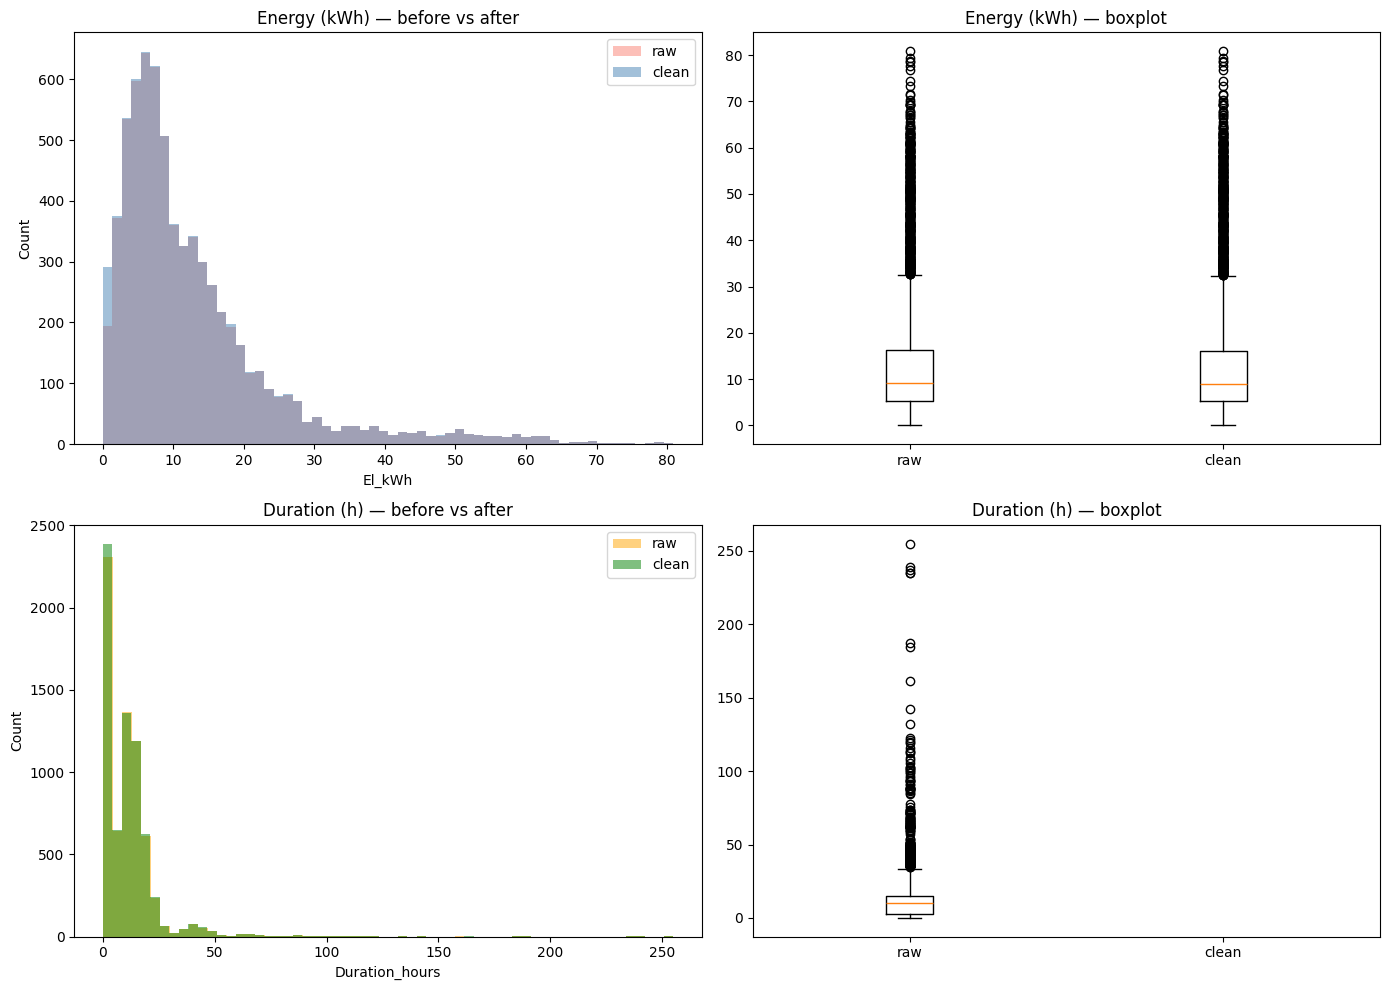

In [3]:
# Before vs After: distributions of El_kWh and Duration
import numpy as np
import matplotlib.pyplot as plt

# Create copies for plotting
# Note: df is already cleaned. Reload raw for pre-clean comparison.
raw = pd.read_csv(RAW_PATH, sep=';', decimal=',')
raw['Start_plugin_dt'] = pd.to_datetime(raw['Start_plugin'], dayfirst=True, errors='coerce')
raw['End_plugout_dt'] = pd.to_datetime(raw['End_plugout'], dayfirst=True, errors='coerce')
raw['Duration_hours_calc'] = (raw['End_plugout_dt'] - raw['Start_plugin_dt']).dt.total_seconds() / 3600.0

# Basic raw filters to match cleaned logic (without extreme cuts) for fair comparison
raw_valid = raw.dropna(subset=['Start_plugin_dt','End_plugout_dt']).copy()
raw_valid = raw_valid[raw_valid['End_plugout_dt'] >= raw_valid['Start_plugin_dt']]
raw_valid = raw_valid[raw_valid['El_kWh'] > 0]
raw_valid = raw_valid[raw_valid['Duration_hours'] > 0.05]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Energy histogram
axes[0,0].hist(raw_valid['El_kWh'], bins=60, alpha=0.5, label='raw', color='salmon')
axes[0,0].hist(df['El_kWh'], bins=60, alpha=0.5, label='clean', color='steelblue')
axes[0,0].set_title('Energy (kWh) — before vs after')
axes[0,0].set_xlabel('El_kWh')
axes[0,0].set_ylabel('Count')
axes[0,0].legend()

# Energy boxplot
axes[0,1].boxplot([raw_valid['El_kWh'], df['El_kWh']], labels=['raw','clean'])
axes[0,1].set_title('Energy (kWh) — boxplot')

# Duration histogram
axes[1,0].hist(raw_valid['Duration_hours'], bins=60, alpha=0.5, label='raw', color='orange')
axes[1,0].hist(df['Duration_hours'], bins=60, alpha=0.5, label='clean', color='green')
axes[1,0].set_title('Duration (h) — before vs after')
axes[1,0].set_xlabel('Duration_hours')
axes[1,0].set_ylabel('Count')
axes[1,0].legend()

# Duration boxplot
axes[1,1].boxplot([raw_valid['Duration_hours'], df['Duration_hours']], labels=['raw','clean'])
axes[1,1].set_title('Duration (h) — boxplot')

plt.tight_layout()
plt.show()

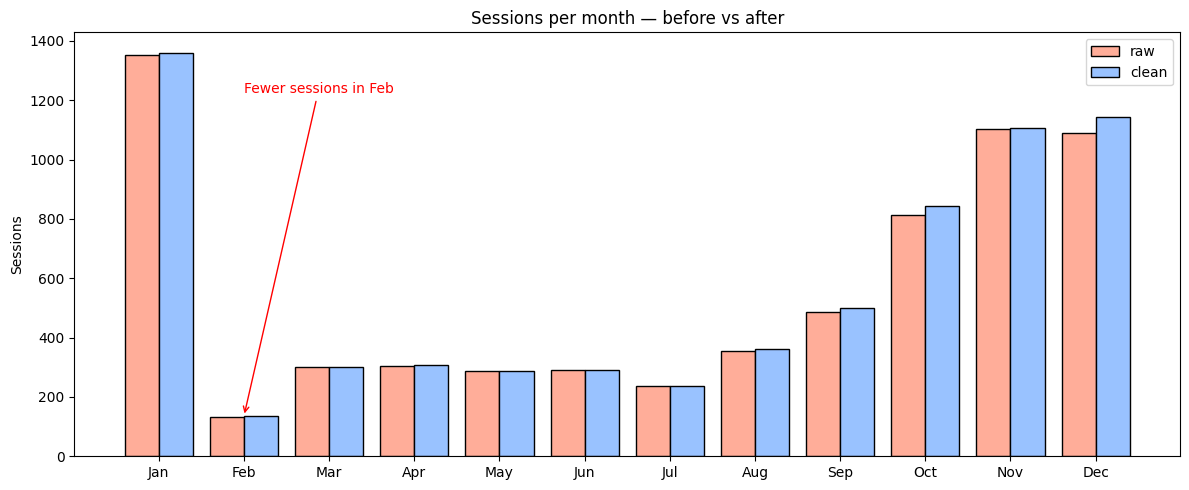

In [4]:
# Month distribution comparison (highlighting February)
import matplotlib.pyplot as plt

# Month short names order for consistent display
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Raw month counts (valid raw as earlier)
raw_month = raw_valid.copy()
raw_month['month_plugin'] = raw_month['Start_plugin_dt'].dt.strftime('%b')
raw_counts = raw_month['month_plugin'].value_counts().reindex(month_order)

# Clean month counts
clean_counts = df['month_plugin'].value_counts().reindex(month_order)

fig, ax = plt.subplots(figsize=(12,5))
bar_width = 0.4
x = np.arange(len(month_order))

ax.bar(x - bar_width/2, raw_counts.values, width=bar_width, label='raw', color='#ffad99', edgecolor='black')
ax.bar(x + bar_width/2, clean_counts.values, width=bar_width, label='clean', color='#99c2ff', edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(month_order)
ax.set_ylabel('Sessions')
ax.set_title('Sessions per month — before vs after')
ax.legend()

# Highlight February
feb_index = month_order.index('Feb')
ax.annotate('Fewer sessions in Feb', xy=(x[feb_index], (clean_counts.values[feb_index] or 0)),
            xytext=(x[feb_index], (max(clean_counts.values[~pd.isna(clean_counts.values)]) if np.isfinite(np.nanmax(clean_counts.values)) else 0) * 0.9),
            arrowprops=dict(arrowstyle='->', color='red'), color='red')

plt.tight_layout()
plt.show()

In [ ]:
# Optional: Save figures to fig/cleanup/
import os
out_fig_dir = 'fig/cleanup'
os.makedirs(out_fig_dir, exist_ok=True)

# Re-generate and save key plots quickly
fig1, axes1 = plt.subplots(1, 2, figsize=(12,5))
axes1[0].hist(raw_valid['El_kWh'], bins=60, alpha=0.5, label='raw', color='salmon')
axes1[0].hist(df['El_kWh'], bins=60, alpha=0.5, label='clean', color='steelblue')
axes1[0].set_title('Energy (kWh) — before vs after')
axes1[0].legend()
axes1[1].hist(raw_valid['Duration_hours'], bins=60, alpha=0.5, label='raw', color='orange')
axes1[1].hist(df['Duration_hours'], bins=60, alpha=0.5, label='clean', color='green')
axes1[1].set_title('Duration (h) — before vs after')
axes1[1].legend()
fig1.tight_layout()
fig1.savefig(os.path.join(out_fig_dir, 'before_after_histograms.png'), dpi=120)

fig2, ax2 = plt.subplots(figsize=(12,5))
bar_width = 0.4
x = np.arange(len(month_order))
ax2.bar(x - bar_width/2, raw_counts.values, width=bar_width, label='raw', color='#ffad99', edgecolor='black')
ax2.bar(x + bar_width/2, clean_counts.values, width=bar_width, label='clean', color='#99c2ff', edgecolor='black')
ax2.set_xticks(x)
ax2.set_xticklabels(month_order)
ax2.set_ylabel('Sessions')
ax2.set_title('Sessions per month — before vs after')
ax2.legend()
fig2.tight_layout()
fig2.savefig(os.path.join(out_fig_dir, 'month_distribution_comparison.png'), dpi=120)

print('Saved figures to', out_fig_dir)

In [7]:
# Ensure data directory exists and save cleaned CSV
import os
os.makedirs('data', exist_ok=True)
df.to_csv('data/ev_sessions_clean.csv', index=False)
print('Wrote cleaned CSV to', os.path.abspath('data/ev_sessions_clean.csv'))

Wrote cleaned CSV to /Users/cyrils/Developer/Python/NeuralNetworks/project/ev_project/data/ev_sessions_clean.csv
